In [1]:
from pathlib import Path
import time
import glob
import json
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split, KFold

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import ModelSummary

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('../')

from utils.config_dataset import *
from utils.ClassDataset import CusDataset
from utils.ClassPredictor import LSTM_PRED, GuidedLSTM_PRED, LSTM_PRED_ALLMED, GuidedLSTM_PRED_ALLMED, mae_loss

RANDOMSEED=2024
torch.manual_seed(RANDOMSEED)
np.random.seed(RANDOMSEED)

In [2]:
def mae_loss(x_, x, los=False):
    if los:
        loss = np.mean(np.abs(x - x_))
    else:
        mask_valid = np.where(x!=-1)
        loss = np.mean(np.abs(x[mask_valid] - x_[mask_valid]))
    return loss

def calculate_and_save_loss_cv(file_output, seq_len, X_test, display=True, los=False, los_label=None):
    print(os.path.dirname(file_output))
    cv_output = pickle.load(open(file_output, 'rb'))
    output = {}
    for i, k in enumerate(cv_output):
        output[i] = np.concatenate(cv_output[k])
    
    loss_cv = {}
    if los:
        for k in output:
            loss_cv[k] = mae_loss(output[k], los_label, los)
    else:
        for k in output:
            loss_cv[k] = mae_loss(output[k], X_test[:, -seq_len:, 10:])

    output_mean = (output[0] + output[1] + output[2] + output[3] + output[4]) / 5
    if los:
        loss_mean = mae_loss(output_mean, los_label, los)
    else:
        loss_mean = mae_loss(output_mean, X_test[:, -seq_len:, 10:])

    with open(os.path.join(os.path.dirname(file_output), 'eval_result.txt'), 'a') as f:
        for k in loss_cv:
            f.write(f'LOSS - Kfold {k}: {loss_cv[k]}\n')
            if display:
                print(f'\tLOSS - Kfold {k}: {loss_cv[k]}')
        f.write(f'LOSS - mean: {loss_mean}\n')
        if display:
            print(f'\tLOSS - mean: {loss_mean}')

    loss_cv['mean'] = loss_mean
    df = pd.DataFrame.from_dict(loss_cv, orient='index', 
                                columns=[(file_output.split('/')[1], file_output.split('/')[2])])
    return df, output_mean

In [3]:
archive = pickle.load(open(os.path.join(path_processed, 'training_data_allmed.p'), 'rb'))
samples = archive['samples_norm']
sample_dict = archive['sample_dict']
idx_train = archive['idx_train']
idx_test = archive['idx_test']
pid_train = archive['pid_train']
pid_test = archive['pid_test']
del archive

X_test = samples[idx_test]
dataset_test = CusDataset(X_test)
loader_test = DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=32)

# LSTM-PRED

In [40]:
model_paths = {
    'GuidedLSTM-PRED-ALLMED': [
#         'models/GuidedLSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
#         'models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
    ],
#     'LSTM-PRED-ALLMED':[
#         'models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
#         'models/LSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
#         'models/LSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
#     ]
}


for model_type in model_paths:
    for model_path in model_paths[model_type]:
    
        params = model_path.split('/')[2]

        include_med = False
        kfolds = 5
        lr = 1e-3
        batchsize = 64
        n_emb = int(params.split('-')[1].strip('hidden'))
        n_layer = int(params.split('-')[0].strip('layer'))
        dropout = float(params.split('-')[2].strip('dropout'))
        device = 'cuda'
        seq_len = 181
        n_feat = 10

        config = {
            'device': device,
            "seq_len": seq_len,
            "n_feat": n_feat,
            "n_emb": n_emb,
            'n_layer': n_layer,
            "lr": lr,
            "dropout": dropout,
            'include_med': include_med,
        }


        model_files = glob.glob(f'{model_path}/*.ckpt')

        preds = {model_file:[] for model_file in model_files}
        losses = {model_file:[] for model_file in model_files}
        for model_file in model_files:
            print('Evaluating: ', model_file)
            print('Save model output to:', os.path.join(model_path, 'test_preds.p'))

            if model_type.replace('-','_') == 'LSTM_PRED_ALLMED':
                model = LSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            elif model_type.replace('-','_') == 'GuidedLSTM_PRED_ALLMED':
                model = GuidedLSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            else:
                print(f'{model_type} is not supported!')
            model.to(device)
            model.eval()

            # print(model.lstm.all_weights.type)

            for X in tqdm(loader_test):
                pred = model(X['data'][:, :91, :].to(device))
                preds[model_file].append(pred.cpu().detach().numpy())

        pickle.dump(preds, open(os.path.join(model_path, 'test_preds.p'), 'wb'))

Evaluating:  models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv0epoch64-val_loss0.01525.ckpt
Save model output to: models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [01:01<00:00,  2.59it/s]


Evaluating:  models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv1epoch52-val_loss0.01549.ckpt
Save model output to: models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [01:02<00:00,  2.51it/s]


Evaluating:  models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv2epoch52-val_loss0.01538.ckpt
Save model output to: models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [01:02<00:00,  2.51it/s]


Evaluating:  models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv3epoch57-val_loss0.01546.ckpt
Save model output to: models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [01:02<00:00,  2.53it/s]


In [43]:
model_paths = {
    'GuidedLSTM-PRED-ALLMED': [
        'models/GuidedLSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
#         'models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
    ],
    'LSTM-PRED-ALLMED':[
        'models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
    ]
}

df_loss_pred = []
model_output_pred = {model_type:{} for model_type in model_paths}

for model_type in model_paths:
    for model_path in model_paths[model_type]:
        file_preds = os.path.join(model_path, 'test_preds.p')
        df, output = calculate_and_save_loss_cv(file_output=file_preds, 
                                                      seq_len=90,
                                                      X_test=X_test, 
                                                      display=True)
        df_loss_pred.append(df)
        model_output_pred[model_type][file_preds.split('/')[2]] = output

models/GuidedLSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.014285133628462628
	LOSS - Kfold 1: 0.014372743299837608
	LOSS - Kfold 2: 0.014400053817107732
	LOSS - Kfold 3: 0.01456837348821688
	LOSS - Kfold 4: 0.014341987048994217
	LOSS - mean: 0.014115913856165879
models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.014539287244264787
	LOSS - Kfold 1: 0.014512556855087995
	LOSS - Kfold 2: 0.014407304364375805
	LOSS - Kfold 3: 0.014498453571577915
	LOSS - Kfold 4: 0.014452421461384337
	LOSS - mean: 0.014094034420612635
models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.015183350045761523
	LOSS - Kfold 1: 0.014357568038980195
	LOSS - Kfold 2: 0.014106308702858191
	LOSS - Kfold 3: 0.014345918898474372
	LOSS - Kfold 4: 0.014179088927533874
	LOSS - mean: 0.014121011118355507
models/LSTM_PRED_ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.01416778547

In [55]:
df_loss_pred_all = pd.concat(df_loss_pred, axis=1)
df_loss_pred_all

,"(GuidedLSTM_PRED_ALLMED, 2layer-128hidden-0.1dropout-64-0.001)","(GuidedLSTM_PRED_ALLMED, 2layer-256hidden-0.1dropout-64-0.001)","(LSTM_PRED_ALLMED, 2layer-128hidden-0.1dropout-64-0.001)","(LSTM_PRED_ALLMED, 2layer-256hidden-0.1dropout-64-0.001)","(LSTM_PRED_ALLMED, 2layer-256hidden-0.2dropout-64-0.001)"
0,0.014285,0.014539,0.015183,0.014168,0.014228
1,0.014373,0.014513,0.014358,0.014224,0.014991
2,0.014400,0.014407,0.014106,0.014193,0.016841
3,0.014568,0.014498,0.014346,0.013982,0.014212
4,0.014342,0.014452,0.014179,0.014710,0.014330
mean,0.014116,0.014094,0.014121,0.013802,0.014357


In [54]:
model_path = 'models/GuidedLSTM_PRED_ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0'
file_preds = os.path.join(model_path, 'test_preds.p')

cv_output = pickle.load(open(file_preds, 'rb'))
output = {}
for i, k in enumerate(cv_output):
    output[i] = np.concatenate(cv_output[k])

loss_cv = {}
for k in output:
    loss_cv[k] = mae_loss(output[k], X_test[:, -90:, 10:])

output_mean = (output[0] + output[1] + output[2] + output[3]) / 4
loss_mean = mae_loss(output_mean, X_test[:, -90:, 10:])

with open(os.path.join(os.path.dirname(file_preds), 'eval_result.txt'), 'a') as f:
    for k in loss_cv:
        f.write(f'LOSS - Kfold {k}: {loss_cv[k]}\n')
        if display:
            print(f'\tLOSS - Kfold {k}: {loss_cv[k]}')
    f.write(f'LOSS - mean: {loss_mean}\n')
    if display:
        print(f'\tLOSS - mean: {loss_mean}')

	LOSS - Kfold 0: 0.014309751951632485
	LOSS - Kfold 1: 0.014353806533419904
	LOSS - Kfold 2: 0.014465971562118778
	LOSS - Kfold 3: 0.01446558031147178
	LOSS - mean: 0.014059225570904306


# PRED-PRETRAINIED

In [189]:
glob.glob('models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version*')

['models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version_0',
 'models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version_1',
 'models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version_2',
 'models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version_3']

In [ ]:
model_paths = {
    'GuidedLSTM-PRED-ALLMED': []
    'LSTM-PRED-ALLMED': glob.glob('models/LOS_PRED_ALLMED-NO-INFO/0.5dropout-64-0.0001/version*')
}


for model_type in model_paths:
    for model_path in model_paths[model_type]:
        with open(f"{model_path}/data_version.txt", 'r') as f:
            data_version = f.read()
        X_rec, X_enc = pickle.load(open(os.path.join(path_processed, data_version.strip('\n')), 'rb'))
    
        params = model_path.split('/')[2]

        include_med = False
        kfolds = 5
        lr = 1e-3
        batchsize = 64
        n_emb = int(params.split('-')[1].strip('hidden'))
        n_layer = int(params.split('-')[0].strip('layer'))
        dropout = float(params.split('-')[2].strip('dropout'))
        device = 'cuda'
        seq_len = 181
        n_feat = 10

        config = {
            'device': device,
            "seq_len": seq_len,
            "n_feat": n_feat,
            "n_emb": n_emb,
            'n_layer': n_layer,
            "lr": lr,
            "dropout": dropout,
            'include_med': include_med,
        }


        model_files = glob.glob(f'{model_path}/*.ckpt')

        preds = {model_file:[] for model_file in model_files}
        losses = {model_file:[] for model_file in model_files}
        for model_file in model_files:
            print('Evaluating: ', model_file)
            print('Save model output to:', os.path.join(model_path, 'test_preds.p'))

            if model_type.replace('-','_') == 'LSTM_PRED_ALLMED':
                model = LSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            elif model_type.replace('-','_') == 'GuidedLSTM_PRED_ALLMED':
                model = GuidedLSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            else:
                print(f'{model_type} is not supported!')
            model.to(device)
            model.eval()

            # print(model.lstm.all_weights.type)

            for X in tqdm(loader_test):
                pred = model(X['data'][:, :91, :].to(device))
                preds[model_file].append(pred.cpu().detach().numpy())

        pickle.dump(preds, open(os.path.join(model_path, 'test_preds.p'), 'wb'))

In [25]:
model_type = 'LSTM_PRED_ALLMED'
model_path = 'models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_1'


config = pickle.load(open('models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_1/model_config.p', 'rb'))



model_files = glob.glob(f'{model_path}/*.ckpt')

preds = {model_file:[] for model_file in model_files}
losses = {model_file:[] for model_file in model_files}
for model_file in model_files:
    print('Evaluating: ', model_file)
    print('Save model output to:', model_file.replace('.ckpt', '_test_preds.p'))

    if model_type == 'LSTM_PRED_ALLMED':
        model = LSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
    elif model_type == 'GuidedLSTM_PRED_ALLMED':
        model = GuidedLSTM_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
    else:
        print(f'{model_type} is not supported!')
    model.to(device)
    model.eval()

    # print(model.lstm.all_weights.type)

    for X in tqdm(loader_test):
        pred = model(X['data'][:, :91, :].to(device))
        preds[model_file].append(pred.cpu().detach().numpy())

pickle.dump(preds, open(os.path.join(model_path, 'test_preds.p'), 'wb'))

Evaluating:  models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_1/epoch94-val_loss0.01516.ckpt
Save model output to: models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_1/epoch94-val_loss0.01516_test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:29<00:00,  5.35it/s]


In [38]:
model_path = 'models/LSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_1'
file_preds = os.path.join(model_path, 'test_preds.p')

output = pickle.load(open(file_preds, 'rb'))
output = np.concatenate(list(output.items())[0][1])

loss = mae_loss(output, X_test[:, -90:, 10:])
with open(os.path.join(os.path.dirname(file_preds), 'eval_result.txt'), 'a') as f:
    f.write(f'LOSS: {loss}\n')
    if display:
        print(f'\tLOSS: {loss}')

	LOSS: 0.014765985956859422


In [17]:
model_path = 'models/GuidedLSTM_PRED_ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0'
file_preds = os.path.join(model_path, 'test_preds.p')

calculate_and_save_loss_cv(file_output=file_preds, seq_len=90, X_test=X_test, display=True)

LOSS - Kfold 0: 0.014320240650643067
LOSS - Kfold 1: 0.014406859108730435
LOSS - Kfold 2: 0.014436905187303662
LOSS - Kfold 3: 0.014606658168388392
LOSS - Kfold 4: 0.014372142519493312
LOSS - mean: 0.014128130745578676


In [63]:
lstm_preds = model_output_pred['LSTM-PRED-ALLMED']['2layer-128hidden-0.1dropout-64-0.001']
guidedlstm_preds = model_output_pred['GuidedLSTM-PRED-ALLMED']['2layer-128hidden-0.1dropout-64-0.001']

sort_max_diff = np.argsort(np.abs(lstm_preds - guidedlstm_preds).mean(axis=1).mean(axis=1))[::-1]

loss_glstm = []
for pred in guidedlstm_preds:
    loss = mae_loss(pred, X_test[:,])
loss_glstm = np.mean(np.mean(np.abs(guidedlstm_preds - X_test[:, -90:, 10:]), axis=1), axis=1)
idx_loss_sort = np.argsort(loss_glstm)

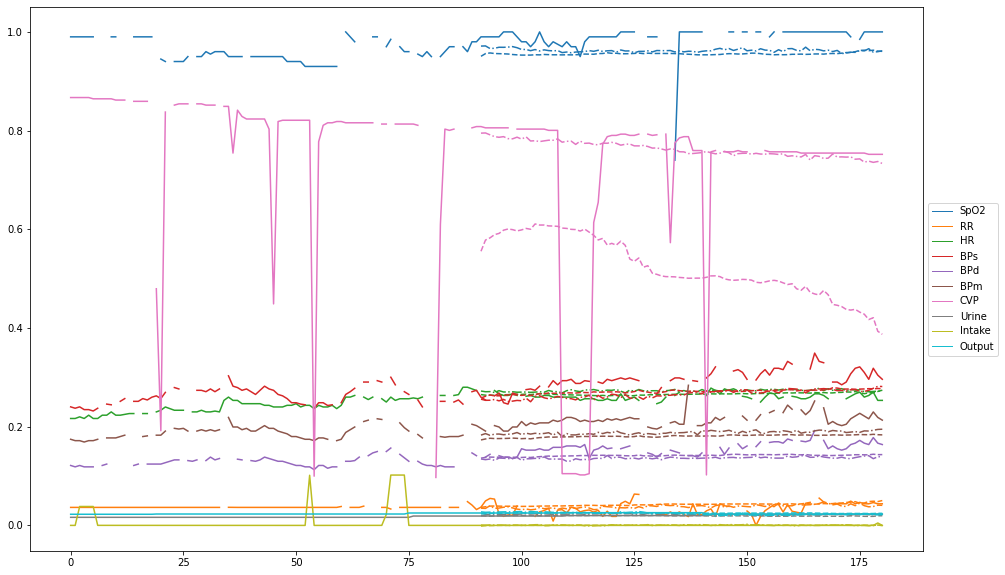

In [109]:
idx_arg = 7
idx = sort_max_diff[idx_arg]
# idx = idx_loss_sort[idx_arg]
x = X_test[idx].copy()
x[np.where(x==-1)] = np.nan

labels = [
    'SpO2',
    'RR',
    'HR',
    'BPs',
    'BPd',
    'BPm',
    'CVP',
    'Urine',
    'Intake',
    'Output',
]

fig, ax = plt.subplots(1,1,figsize=(16,10))
colors = plt.cm.tab10
for j in range(10):
    ax.plot(range(181), x[:, 10+j], '-', color=colors(j))
    ax.plot(range(91,181), lstm_preds[idx, :, j], '--', color=colors(j))
    ax.plot(range(91,181), guidedlstm_preds[idx, :, j], '-.', color=colors(j))
#     line = ax.plot(range(181), x[:, 10+j], '-', color=colors(j), label='groundtruth')
#     ax.plot(range(91,181), lstm_preds_mean[idx, :, j], '--', color=colors(j), label='LSTM')
#     ax.plot(range(91,181), guidedlstm_preds_mean[idx, :, j], '-.', color=colors(j), label='Guided LSTM')


lines = [Line2D([0], [0], color=colors(i), lw=1, label=labels[i]) for i in range(10)]
plt.legend(handles = lines, loc='center left', bbox_to_anchor=(1, 0.5));

In [105]:
save_path = 'plots/vitals_pred'
Path(save_path).mkdir(parents=True, exist_ok=True)

for idx_arg in tqdm(range(2000)):
    idx = sort_max_diff[idx_arg]
    # idx = idx_loss_sort[idx_arg]
    x = X_test[idx].copy()
    if len(x[x==-1]) / (181*10) > .3:
        continue
    x[np.where(x==-1)] = np.nan

    labels = [
        'SpO2',
        'RR',
        'HR',
        'BPs',
        'BPd',
        'BPm',
        'CVP',
        'Urine',
        'Intake',
        'Output',
    ]

    fig, ax = plt.subplots(1,1,figsize=(16,10))
    colors = plt.cm.tab10
    for j in range(10):
        ax.plot(range(181), x[:, 10+j], '-', color=colors(j))
        ax.plot(range(91,181), lstm_preds[idx, :, j], '--', color=colors(j))
        ax.plot(range(91,181), guidedlstm_preds[idx, :, j], '-.', color=colors(j))
    #     line = ax.plot(range(181), x[:, 10+j], '-', color=colors(j), label='groundtruth')
    #     ax.plot(range(91,181), lstm_preds_mean[idx, :, j], '--', color=colors(j), label='LSTM')
    #     ax.plot(range(91,181), guidedlstm_preds_mean[idx, :, j], '-.', color=colors(j), label='Guided LSTM')


    lines = [Line2D([0], [0], color=colors(i), lw=1, label=labels[i]) for i in range(10)]
    plt.legend(handles = lines, loc='center left', bbox_to_anchor=(1, 0.5));
    fig.savefig(os.path.join(save_path, f'{idx}.png'), dpi=fig.dpi)
    plt.close()

In [103]:
x = X_test[idx].copy()
len(x[x==-1]) / (181*10)

0.11878453038674033

In [101]:
ax.lines[0]

In [19]:
labels = pickle.load(open(os.path.join(path_processed, 'training_label_allmed.p'), 'rb'))

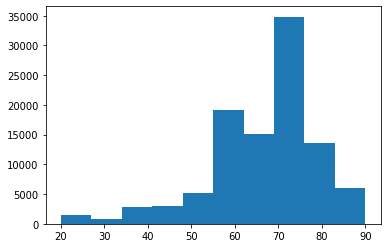

In [57]:
plt.hist(labels['age']);

(array([ 4031.,  7396., 12441., 15486., 13965., 14326., 14027., 10609.,
         6901.,  2801.]),
 array([-2.07944154, -1.53931655, -0.99919155, -0.45906656,  0.08105843,
         0.62118343,  1.16130842,  1.70143341,  2.24155841,  2.7816834 ,
         3.3218084 ]),
 <BarContainer object of 10 artists>)

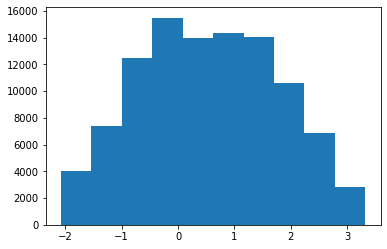

In [20]:
los_ = np.array(labels['los'])
los_ = np.log(los_)
plt.hist(los_)

-2.0794415416798357 3.3218083954513595


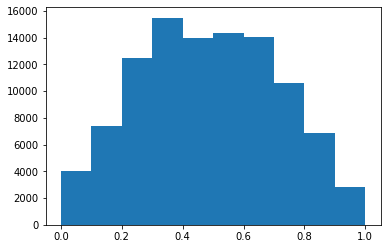

In [21]:
loglos_min = los_.min()
loglos_max = los_.max()
los_ = (los_ - loglos_min) / (loglos_max-loglos_min)
plt.hist(los_)
print(loglos_min, loglos_max)

In [ ]:
los_[mask] = 

plt.hist(np.log(labels['los']));

(array([1.0000e+00, 1.0000e+00, 3.1000e+01, 1.1300e+02, 5.3300e+02,
        2.4020e+03, 1.1250e+04, 3.3415e+04, 3.7087e+04, 1.7150e+04]),
 array([-14.91975254, -13.42777729, -11.93580203, -10.44382678,
         -8.95185152,  -7.45987627,  -5.96790102,  -4.47592576,
         -2.98395051,  -1.49197525,   0.        ]),
 <BarContainer object of 10 artists>)

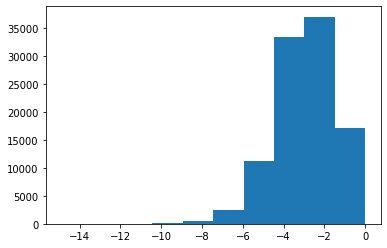

In [42]:
plt.hist(los_)

In [4]:
8*8*52, 40*40*128

(3328, 204800)

In [5]:
import numpy as np

In [146]:
for i in np.linspace(-2, 3, 10):
    print(f'{i:.1f}\t{np.exp(i):.3f}\t{np.exp(i+0.5):.3f}')

-2.0	0.135	0.223
-1.4	0.236	0.389
-0.9	0.411	0.678
-0.3	0.717	1.181
0.2	1.249	2.059
0.8	2.177	3.589
1.3	3.794	6.255
1.9	6.612	10.901
2.4	11.524	19.000
3.0	20.086	33.115


In [1]:
import pandas as pd

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv'
sales_transaction = pd.read_csv(data_url)
data = sales_transaction[[f'Normalized {i}' for i in range(52)]].values

# AE

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils.ClassAE import LSTM_AE_ALLMED, GuidedLSTM_AE_ALLMED

In [11]:
model_paths = {
    'GuidedLSTM-AE-ALLMED': [
        'models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0',
    ],
    'LSTM-AE-ALLMED':[
        'models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0'
    ]
}

for model_type in model_paths:
    for model_path in model_paths[model_type]:
    
        params = model_path.split('/')[2]

        include_med = False
        kfolds = 5
        lr = 1e-3
        batchsize = 64
        n_emb = int(params.split('-')[1].strip('hidden'))
        n_layer = int(params.split('-')[0].strip('layer'))
        dropout = float(params.split('-')[2].strip('dropout'))
        device = 'cuda'
        seq_len = 181
        n_feat = 10

        config = {
            'device': device,
            "seq_len": seq_len,
            "n_feat": n_feat,
            "n_emb": n_emb,
            'n_layer': n_layer,
            "lr": lr,
            "dropout": dropout,
            'include_med': include_med,
        }


        model_files = glob.glob(f'{model_path}/*.ckpt')

        preds = {model_file:[] for model_file in model_files}
        losses = {model_file:[] for model_file in model_files}
        for model_file in model_files:
            print('Evaluating: ', model_file)
            print('Save model output to:', os.path.join(model_path, 'test_preds.p'))

            if model_type == 'LSTM-AE-ALLMED':
                model = LSTM_AE_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            elif model_type == 'GuidedLSTM-AE-ALLMED':
                model = GuidedLSTM_AE_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            else:
                print(f'{model_type} is not supported!')
            model.to(device)
            model.eval()

            # print(model.lstm.all_weights.type)

            for X in tqdm(loader_test):
                pred = model(X['data'].to(device))
                preds[model_file].append(pred.cpu().detach().numpy())

        pickle.dump(preds, open(os.path.join(model_path, 'test_preds.p'), 'wb'))

        del model

Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv0epoch38-val_loss0.01525.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.13it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv1epoch115-val_loss0.00857.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.31it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv2epoch101-val_loss0.00883.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.06it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv3epoch130-val_loss0.00834.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.09it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv4epoch182-val_loss0.01503.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.79it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv0epoch247-val_loss0.00897.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.39it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv1epoch248-val_loss0.00753.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.34it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv2epoch104-val_loss0.01497.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:34<00:00,  4.53it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv3epoch110-val_loss0.00830.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:35<00:00,  4.44it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv4epoch249-val_loss0.00849.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:34<00:00,  4.55it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv0epoch90-val_loss0.01522.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:33<00:00,  4.69it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv1epoch249-val_loss0.00813.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:30<00:00,  5.15it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv2epoch57-val_loss0.01535.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:32<00:00,  4.83it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv3epoch247-val_loss0.00886.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.31it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv4epoch245-val_loss0.00890.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:32<00:00,  4.87it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv0epoch249-val_loss0.00943.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:39<00:00,  4.05it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv1epoch103-val_loss0.01537.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:38<00:00,  4.06it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv2epoch85-val_loss0.01544.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:39<00:00,  4.01it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv3epoch65-val_loss0.01528.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:37<00:00,  4.27it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv4epoch62-val_loss0.01539.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:38<00:00,  4.12it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv0epoch117-val_loss0.00878.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:15<00:00,  9.97it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv1epoch77-val_loss0.00915.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.11it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv2epoch246-val_loss0.00724.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.44it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv3epoch249-val_loss0.00881.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.28it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv4epoch247-val_loss0.00839.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.22it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv0epoch99-val_loss0.00831.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.37it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv1epoch92-val_loss0.00828.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.33it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv2epoch249-val_loss0.00785.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:35<00:00,  4.49it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv3epoch193-val_loss0.00753.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:35<00:00,  4.47it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/cv4epoch115-val_loss0.00813.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.31it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/cv0epoch66-val_loss0.01535.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:33<00:00,  4.69it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/cv1epoch248-val_loss0.00816.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:34<00:00,  4.64it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/cv2epoch249-val_loss0.01360.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:34<00:00,  4.55it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/cv3epoch249-val_loss0.00919.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:32<00:00,  4.84it/s]


Evaluating:  models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/cv4epoch101-val_loss0.01536.ckpt
Save model output to: models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:31<00:00,  4.99it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv0epoch88-val_loss0.00752.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:15<00:00, 10.33it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv1epoch207-val_loss0.00685.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.55it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv2epoch248-val_loss0.00803.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.40it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv3epoch83-val_loss0.00780.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.99it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/cv4epoch90-val_loss0.00750.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.52it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv0epoch100-val_loss0.00610.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:34<00:00,  4.63it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv1epoch179-val_loss0.00611.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:28<00:00,  5.56it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv2epoch59-val_loss0.00716.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:26<00:00,  6.06it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv3epoch156-val_loss0.00640.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:26<00:00,  5.99it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/cv4epoch248-val_loss0.00625.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:37<00:00,  4.18it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv0epoch249-val_loss0.00715.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:37<00:00,  4.26it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv1epoch248-val_loss0.00686.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:35<00:00,  4.40it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv2epoch192-val_loss0.00652.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:39<00:00,  3.98it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv3epoch15-val_loss0.02532.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:36<00:00,  4.37it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/cv4epoch119-val_loss0.00692.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:37<00:00,  4.23it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv0epoch249-val_loss0.00920.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:31<00:00,  5.03it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv1epoch120-val_loss0.00704.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:27<00:00,  5.77it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv2epoch248-val_loss0.00594.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:27<00:00,  5.75it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv3epoch246-val_loss0.00697.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:28<00:00,  5.53it/s]


Evaluating:  models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/cv4epoch66-val_loss0.02535.ckpt
Save model output to: models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:29<00:00,  5.31it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv0epoch240-val_loss0.00690.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:16<00:00,  9.35it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv1epoch130-val_loss0.00719.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:18<00:00,  8.50it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv2epoch139-val_loss0.00689.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 10.63it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv3epoch66-val_loss0.00766.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:18<00:00,  8.58it/s]


Evaluating:  models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/cv4epoch68-val_loss0.00815.ckpt
Save model output to: models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 10.87it/s]


In [12]:
model_paths = {
    'GuidedLSTM-AE-ALLMED': [
        'models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.2dropout-64-0.001/version_0',
        'models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.2dropout-64-0.001/version_0',
    ],
    'LSTM-AE-ALLMED':[
        'models/LSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0',
        'models/LSTM-AE-ALLMED/2layer-128hidden-0.2dropout-64-0.001/version_0'
    ]
}

df_loss_ae = []
model_output_ae = {model_type:{} for model_type in model_paths}

for model_type in model_paths:
    for model_path in model_paths[model_type]:
        file_preds = os.path.join(model_path, 'test_preds.p')
        df, output = calculate_and_save_loss_cv(file_output=file_preds, 
                                                      seq_len=181,
                                                      X_test=X_test, 
                                                      display=True)
        df_loss_ae.append(df)
        model_output_ae[model_type][file_preds.split('/')[2]] = output

models/GuidedLSTM-AE-ALLMED/2layer-128hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.014705835317833505
	LOSS - Kfold 1: 0.008190708796339442
	LOSS - Kfold 2: 0.008468106200317013
	LOSS - Kfold 3: 0.007966087449821066
	LOSS - Kfold 4: 0.01422556937527824
	LOSS - mean: 0.009673004759655292
models/GuidedLSTM-AE-ALLMED/2layer-256hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.008446503089154556
	LOSS - Kfold 1: 0.007114807534119948
	LOSS - Kfold 2: 0.013875309873189802
	LOSS - Kfold 3: 0.007901397138114701
	LOSS - Kfold 4: 0.008010165157389535
	LOSS - mean: 0.00819795716134915
models/GuidedLSTM-AE-ALLMED/3layer-128hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.014524030161322053
	LOSS - Kfold 1: 0.007734498344600258
	LOSS - Kfold 2: 0.014798812397728752
	LOSS - Kfold 3: 0.008431357840442806
	LOSS - Kfold 4: 0.00845495997086832
	LOSS - mean: 0.009806208524029964
models/GuidedLSTM-AE-ALLMED/3layer-256hidden-0.1dropout-64-0.001/version_0
	LOSS - Kfold 0: 0.008741891

In [13]:
df_loss_ae_all = pd.concat(df_loss_ae, axis=1)
df_loss_ae_all

,"(GuidedLSTM-AE-ALLMED, 2layer-128hidden-0.1dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 2layer-256hidden-0.1dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 3layer-128hidden-0.1dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 3layer-256hidden-0.1dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 2layer-128hidden-0.2dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 2layer-256hidden-0.2dropout-64-0.001)","(GuidedLSTM-AE-ALLMED, 3layer-128hidden-0.2dropout-64-0.001)","(LSTM-AE-ALLMED, 2layer-128hidden-0.1dropout-64-0.001)","(LSTM-AE-ALLMED, 2layer-256hidden-0.1dropout-64-0.001)","(LSTM-AE-ALLMED, 3layer-128hidden-0.1dropout-64-0.001)","(LSTM-AE-ALLMED, 3layer-256hidden-0.1dropout-64-0.001)","(LSTM-AE-ALLMED, 2layer-128hidden-0.2dropout-64-0.001)"
0,0.014706,0.008447,0.014524,0.008742,0.008392,0.007910,0.014824,0.007205,0.005813,0.006831,0.008698,0.006588
1,0.008191,0.007115,0.007734,0.014145,0.008746,0.007884,0.007781,0.006533,0.005816,0.006558,0.006709,0.006871
2,0.008468,0.013875,0.014799,0.014527,0.006919,0.007478,0.012937,0.007684,0.006847,0.006231,0.005640,0.006600
3,0.007966,0.007901,0.008431,0.014536,0.008422,0.007130,0.008766,0.007456,0.006088,0.024696,0.006614,0.007331
4,0.014226,0.008010,0.008455,0.014687,0.007967,0.007713,0.014642,0.007142,0.005912,0.006587,0.024739,0.007768
mean,0.009673,0.008198,0.009806,0.012622,0.007705,0.007302,0.010889,0.006847,0.005800,0.008645,0.008846,0.006637


In [ ]:
x_lstm = model_output_ae['LSTM-AE-ALLMED']['2layer-128hidden-0.2dropout-64-0.001']
x_guidedlstm = model_output_ae['GuidedLSTM-AE-ALLMED']['2layer-128hidden-0.2dropout-64-0.001']

sort_max_diff = np.argsort(np.abs(x_lstm - x_guidedlstm).mean(axis=1).mean(axis=1))[::-1]

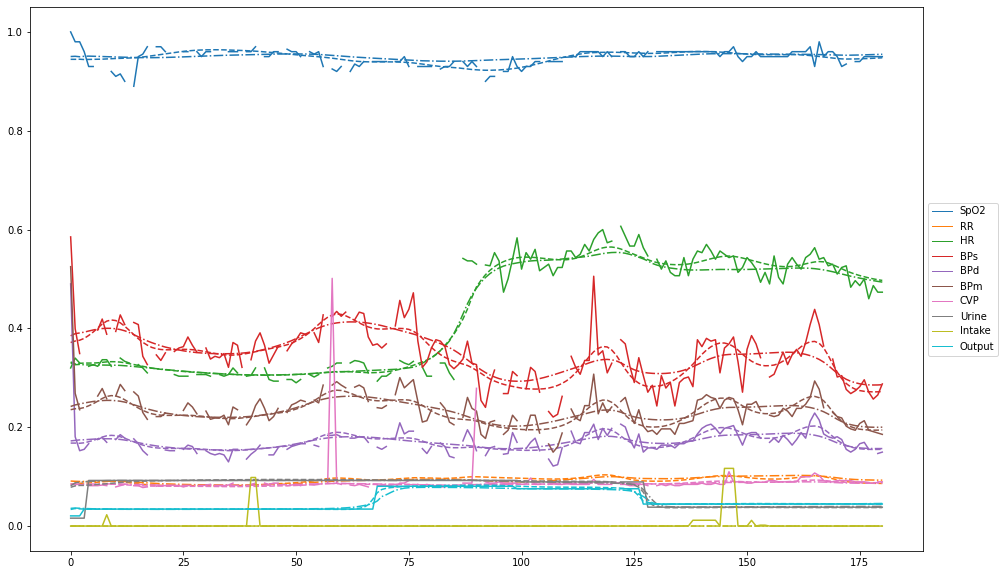

In [114]:
idx_arg = 88
idx = sort_max_diff[idx_arg]
x = X_test[idx].copy()
x[np.where(x==-1)] = np.nan

labels = [
    'SpO2',
    'RR',
    'HR',
    'BPs',
    'BPd',
    'BPm',
    'CVP',
    'Urine',
    'Intake',
    'Output',
]

fig, ax = plt.subplots(1,1,figsize=(16,10))
colors = plt.cm.tab10
for j in range(10):
    ax.plot(range(181), x[:, 10+j], '-', color=colors(j))
    ax.plot(range(181), x_lstm[idx, :, j], '--', color=colors(j))
    ax.plot(range(181), x_guidedlstm[idx, :, j], '-.', color=colors(j))
#     line = ax.plot(range(181), x[:, 10+j], '-', color=colors(j), label='groundtruth')
#     ax.plot(range(91,181), lstm_preds_mean[idx, :, j], '--', color=colors(j), label='LSTM')
#     ax.plot(range(91,181), guidedlstm_preds_mean[idx, :, j], '-.', color=colors(j), label='Guided LSTM')


lines = [Line2D([0], [0], color=colors(i), lw=1, label=labels[i]) for i in range(10)]
plt.legend(handles = lines, loc='center left', bbox_to_anchor=(1, 0.5));


In [106]:
save_path = 'plots/ae'
Path(save_path).mkdir(parents=True, exist_ok=True)

for idx_arg in tqdm(range(2000)):
    idx = sort_max_diff[idx_arg]
    x = X_test[idx].copy()
    if len(x[x==-1]) / (181*10) > .3:
        continue
    x[np.where(x==-1)] = np.nan

    labels = [
        'SpO2',
        'RR',
        'HR',
        'BPs',
        'BPd',
        'BPm',
        'CVP',
        'Urine',
        'Intake',
        'Output',
    ]

    fig, ax = plt.subplots(1,1,figsize=(16,10))
    colors = plt.cm.tab10
    for j in range(10):
        ax.plot(range(181), x[:, 10+j], '-', color=colors(j))
        ax.plot(range(181), x_lstm[idx, :, j], '--', color=colors(j))
        ax.plot(range(181), x_guidedlstm[idx, :, j], '-.', color=colors(j))
    #     line = ax.plot(range(181), x[:, 10+j], '-', color=colors(j), label='groundtruth')
    #     ax.plot(range(91,181), lstm_preds_mean[idx, :, j], '--', color=colors(j), label='LSTM')
    #     ax.plot(range(91,181), guidedlstm_preds_mean[idx, :, j], '-.', color=colors(j), label='Guided LSTM')


    lines = [Line2D([0], [0], color=colors(i), lw=1, label=labels[i]) for i in range(10)]
    plt.legend(handles = lines, loc='center left', bbox_to_anchor=(1, 0.5));
    fig.savefig(os.path.join(save_path, f'{idx}.png'), dpi=fig.dpi)
    plt.close()

# LOS

In [120]:
from utils.ClassEncoderClassifier import GuidedLOS_PRED_ALLMED
from utils.ClassDataset import RegressionDataset

In [121]:
X_rec, X_enc = pickle.load(open(os.path.join(path_processed, 
                                             'training_data_classification-GAE-3-128-01.p'), 'rb'))
X_test = (samples[idx_test], X_rec[idx_test], X_enc[idx_test])

dataset_test = RegressionDataset(X_test, label_test)
loader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=False, num_workers=16)

labels = pickle.load(open(os.path.join(path_processed, 'training_label_allmed_normed.p'), 'rb'))
for k in labels:
    labels[k] = np.array(labels[k])
idx_mortality = np.where(labels['survived']==0)[0]
print(len(idx_train), len(idx_test))
idx_train = list(set(idx_train).difference(set(idx_mortality)))
idx_test = list(set(idx_test).difference(set(idx_mortality)))
print(len(idx_train), len(idx_test))

label_test = {k: labels[k][idx_test] for k in labels}


71102 17923
71102 17923


In [186]:
model_paths = {
    'GuidedLOS-ALLMED': [
#         'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_0',
#         'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1',
#         'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_2',
#         'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3',
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4',
    ],
    'LOS-ALLMED':[
#         'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_0',
#         'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1',
#         'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_2',
        'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3',
    ]
}

for model_type in model_paths:
    for model_path in model_paths[model_type]:
        with open(f"{model_path}/data_version.txt", 'r') as f:
            data_version = f.read()
        
        X_rec, X_enc = pickle.load(open(os.path.join(path_processed, data_version.strip('\n')), 'rb'))
        
            
        X_test = (samples[idx_test], X_rec[idx_test], X_enc[idx_test])
        dataset_test = RegressionDataset(X_test, label_test)
        loader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=False, num_workers=16)

        config = pickle.load(open(os.path.join(model_path, 'model_config.p'), 'rb'))
        with open(os.path.join(model_path, 'data_version.txt'), 'r') as f:
            data_version = f.read()

        config['n_emb'] = int(data_version.split('-')[3])
        model_files = glob.glob(f'{model_path}/*.ckpt')
        print(config)

        preds = {model_file:[] for model_file in model_files}
        losses = {model_file:[] for model_file in model_files}
        for model_file in model_files:
            print('Evaluating: ', model_file)
            print('Save model output to:', os.path.join(model_path, 'test_preds.p'))

            if model_type == 'GuidedLOS-ALLMED':
                model = GuidedLOS_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            elif model_type == 'LOS-ALLMED':
                model = GuidedLOS_PRED_ALLMED.load_from_checkpoint(checkpoint_path=model_file, config=config)
            else:
                print(f'{model_type} is not supported!')
            model.to(device)
            model.eval()

            # print(model.lstm.all_weights.type)

            for batch in tqdm(loader_test):
                x, x_rec, x_enc = batch['data']
                batchsize = x.shape[0]
                info = batch['info']
                y = batch['label'].reshape(batchsize, 1)
                x_info = torch.concat((info['age'][:, None],
                                       info['sex'].reshape(batchsize, -1),
                                       info['apache'].reshape(batchsize, -1)),
                                      dim=1)
                
                pred = model(x[:, :, 10:].to(device), 
                             x_rec.to(device), 
                             x_enc.to(device), 
                             x_info.to(device))
                preds[model_file].append(pred.cpu().detach().numpy())

        pickle.dump(preds, open(os.path.join(model_path, 'test_preds.p'), 'wb'))

        del model

{'device': 'cuda', 'seq_len': 181, 'n_feat': 10, 'lr': 0.0001, 'dropout': 0.5, 'n_emb': 128}
Evaluating:  models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/cv0-epoch53-val_loss0.12834.ckpt
Save model output to: models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:45<00:00, 79.64it/s]


Evaluating:  models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/cv1-epoch65-val_loss0.12794.ckpt
Save model output to: models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:55<00:00, 76.22it/s]


Evaluating:  models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/cv2-epoch68-val_loss0.12687.ckpt
Save model output to: models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:51<00:00, 77.45it/s]


Evaluating:  models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/cv3-epoch63-val_loss0.12859.ckpt
Save model output to: models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:45<00:00, 79.36it/s]


Evaluating:  models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/cv4-epoch76-val_loss0.12933.ckpt
Save model output to: models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:46<00:00, 79.11it/s]


{'device': 'cuda', 'seq_len': 181, 'n_feat': 10, 'lr': 0.0001, 'dropout': 0.5, 'n_emb': 128}
Evaluating:  models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/cv0-epoch81-val_loss0.14349.ckpt
Save model output to: models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:50<00:00, 77.66it/s]


Evaluating:  models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/cv1-epoch75-val_loss0.14247.ckpt
Save model output to: models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:49<00:00, 78.11it/s]


Evaluating:  models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/cv2-epoch90-val_loss0.14103.ckpt
Save model output to: models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:43<00:00, 80.04it/s]


Evaluating:  models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/cv3-epoch77-val_loss0.14282.ckpt
Save model output to: models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [03:49<00:00, 78.00it/s]


Evaluating:  models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/cv4-epoch88-val_loss0.14351.ckpt
Save model output to: models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3/test_preds.p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17923/17923 [04:01<00:00, 74.35it/s]


In [187]:
model_paths = {
    'GuidedLOS-ALLMED': [
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_0',
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1',
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_2',
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3',
        'models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_4',
    ],
    'LOS-ALLMED':[
        'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_0',
        'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1',
        'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_2',
        'models/LOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3',
    ]
}
df_loss_los = []
model_output_los = {model_type:{} for model_type in model_paths}

for model_type in model_paths:
    for model_path in model_paths[model_type]:
        file_preds = os.path.join(model_path, 'test_preds.p')
        df, output = calculate_and_save_loss_cv(file_output=file_preds, 
                                                seq_len=181,
                                                X_test=X_test, 
                                                display=True,
                                                los=True,
                                                los_label=label_test['loglos']
                                               )
        df_loss_los.append(df)
        model_output_los[model_type][file_preds.split('/')[2]] = output

models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_0
	LOSS - Kfold 0: 0.23370094665892266
	LOSS - Kfold 1: 0.23384234803827425
	LOSS - Kfold 2: 0.2332387589564645
	LOSS - Kfold 3: 0.23263483447307337
	LOSS - Kfold 4: 0.2315329216211645
	LOSS - mean: 0.23157498239969398
models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1
	LOSS - Kfold 0: 0.23089569618616002
	LOSS - Kfold 1: 0.2306336849028196
	LOSS - Kfold 2: 0.2325221309381363
	LOSS - Kfold 3: 0.2296329835015652
	LOSS - Kfold 4: 0.2332070453325095
	LOSS - mean: 0.22972393500450963
models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_2
	LOSS - Kfold 0: 0.23174509747060854
	LOSS - Kfold 1: 0.23274032850920423
	LOSS - Kfold 2: 0.23280933393962033
	LOSS - Kfold 3: 0.23095714765902886
	LOSS - Kfold 4: 0.23256485739885552
	LOSS - mean: 0.23074121727707617
models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_3
	LOSS - Kfold 0: 0.23075466623524354
	LOSS - Kfold 1: 0.2320774303234387
	LOSS - Kfold 2: 0.2307999102396729


In [188]:
df_loss_los_all = pd.concat(df_loss_los, axis=1)
df_loss_los_all

,"(GuidedLOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(GuidedLOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(GuidedLOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(GuidedLOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(GuidedLOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(LOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(LOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(LOS_PRED_ALLMED, 0.5dropout-64-0.0001)","(LOS_PRED_ALLMED, 0.5dropout-64-0.0001)"
0,0.233701,0.230896,0.231745,0.230755,0.230955,0.229447,0.230680,0.233596,0.230714
1,0.233842,0.230634,0.232740,0.232077,0.233670,0.229875,0.230488,0.229686,0.226016
2,0.233239,0.232522,0.232809,0.230800,0.231869,0.229748,0.229059,0.231034,0.228433
3,0.232635,0.229633,0.230957,0.230639,0.230897,0.228771,0.233039,0.232785,0.228136
4,0.231533,0.233207,0.232565,0.232481,0.232778,0.227787,0.230431,0.231230,0.227402
mean,0.231575,0.229724,0.230741,0.229912,0.230702,0.226709,0.228639,0.229341,0.226107


In [17]:
labels = pickle.load(open(os.path.join(path_processed, 'training_label_allmed_normed.p'), 'rb'))
for k in labels:
    labels[k] = np.array(labels[k])
idx_mortality = np.where(labels['survived']==0)[0]
print(len(idx_train), len(idx_test))
idx_train = list(set(idx_train).difference(set(idx_mortality)))
idx_test = list(set(idx_test).difference(set(idx_mortality)))
print(len(idx_train), len(idx_test))

label_test = {k: labels[k][idx_test] for k in labels}

81800 20183
71102 17923


In [18]:
file_preds = os.path.join('models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1', 'test_preds.p')
df, output = calculate_and_save_loss_cv(file_output=file_preds, 
                                                seq_len=181,
                                                X_test=X_test, 
                                                display=True,
                                                los=True,
                                                los_label=label_test['loglos']
                                               )

models/GuidedLOS_PRED_ALLMED/0.5dropout-64-0.0001/version_1
	LOSS - Kfold 0: 0.23089569618616168
	LOSS - Kfold 1: 0.23063368490282027
	LOSS - Kfold 2: 0.23252213093813437
	LOSS - Kfold 3: 0.22963298350156283
	LOSS - Kfold 4: 0.23320704533251124
	LOSS - mean: 0.22972393500450772


In [22]:
labels.keys()

dict_keys(['pharmaid', 'apache', 'sex', 'age', 'los', 'survived', 'loglos'])

In [24]:
los_raw = np.array(labels['los'])[idx_test]
los_raw.shape

(17923,)

In [26]:
los_raw[:10]

array([ 0.81041667,  9.56967523,  0.62009363,  0.69544375, 15.67013889,
       15.66319444, 15.66041667,  0.49375   , 15.65625   ,  0.66518958])

In [27]:
los_pred[:10]

array([[0.6623359 ],
       [4.0473266 ],
       [0.54771906],
       [2.326441  ],
       [7.6908436 ],
       [6.4989533 ],
       [7.9673524 ],
       [0.9120541 ],
       [5.9788513 ],
       [3.9005594 ]], dtype=float32)

In [25]:
los_pred = []
for pred in output:
    l = pred * (loglos_max - loglos_min) + loglos_min
    l = np.exp(l)
    los_pred.append(l)
los_pred = np.array(los_pred)
los_pred.shape

(17923, 1)

In [28]:
los_mae = mae_loss(los_pred.flatten(), los_raw)

In [56]:
los_ae = np.abs(los_pred.flatten() - los_raw)

ae_plot = []
for i in range(1, 20):
    idx = np.where((los_raw>i-1) & (los_raw<=i))
    ae = los_ae[idx]
    ae_plot.append(ae)

(array([ 732., 1365., 2291., 2764., 2404., 2306., 2548., 1862., 1049.,
         602.]),
 array([0.        , 0.09962821, 0.19925642, 0.29888464, 0.39851285,
        0.49814106, 0.59776927, 0.69739748, 0.7970257 , 0.89665391,
        0.99628212]),
 <BarContainer object of 10 artists>)

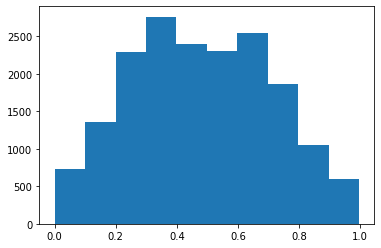

In [65]:
plt.hist(label_test['loglos'])

(array([ 107., 1055., 1642., 2586., 2948., 3500., 4080., 1697.,  276.,
          32.]),
 array([0.01769219, 0.11169389, 0.20569558, 0.29969728, 0.393699  ,
        0.4877007 , 0.5817024 , 0.6757041 , 0.7697058 , 0.8637075 ,
        0.9577092 ], dtype=float32),
 <BarContainer object of 10 artists>)

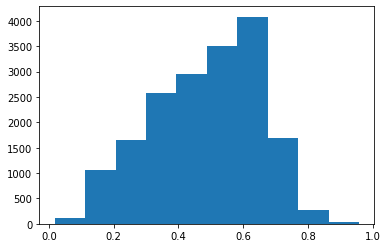

In [64]:
plt.hist(output)

In [57]:
for i, ae in enumerate(ae_plot):
    print(f'LOS {i} - {i+1}:\t {np.mean(ae):.2f} - {np.std(ae):.2f}')

LOS 0 - 1:	 1.64 - 1.69
LOS 1 - 2:	 1.42 - 1.48
LOS 2 - 3:	 1.50 - 1.25
LOS 3 - 4:	 1.81 - 1.26
LOS 4 - 5:	 2.38 - 1.47
LOS 5 - 6:	 3.01 - 1.55
LOS 6 - 7:	 4.04 - 1.66
LOS 7 - 8:	 4.68 - 1.87
LOS 8 - 9:	 5.73 - 1.84
LOS 9 - 10:	 6.24 - 2.12
LOS 10 - 11:	 7.25 - 2.27
LOS 11 - 12:	 7.63 - 2.84
LOS 12 - 13:	 8.91 - 2.80
LOS 13 - 14:	 10.18 - 2.34
LOS 14 - 15:	 11.87 - 1.84
LOS 15 - 16:	 11.24 - 2.96
LOS 16 - 17:	 12.57 - 2.97
LOS 17 - 18:	 14.52 - 2.08
LOS 18 - 19:	 15.46 - 2.00


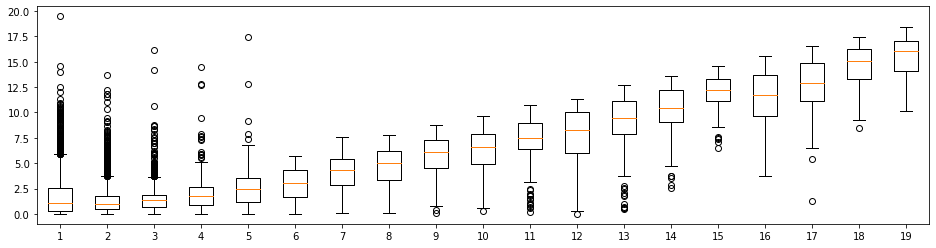

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.boxplot(ae_plot);

In [42]:
for x in ae_plot:
    print(x.shape)

(6870, 17923)
(3027, 17923)
(1735, 17923)
(1376, 17923)
(1070, 17923)
(744, 17923)
(571, 17923)
(430, 17923)
(354, 17923)
(261, 17923)
(199, 17923)
(227, 17923)
(164, 17923)
(131, 17923)
(80, 17923)
(92, 17923)
(72, 17923)
(75, 17923)
(67, 17923)


In [40]:
len(ae_plot[2])

1735

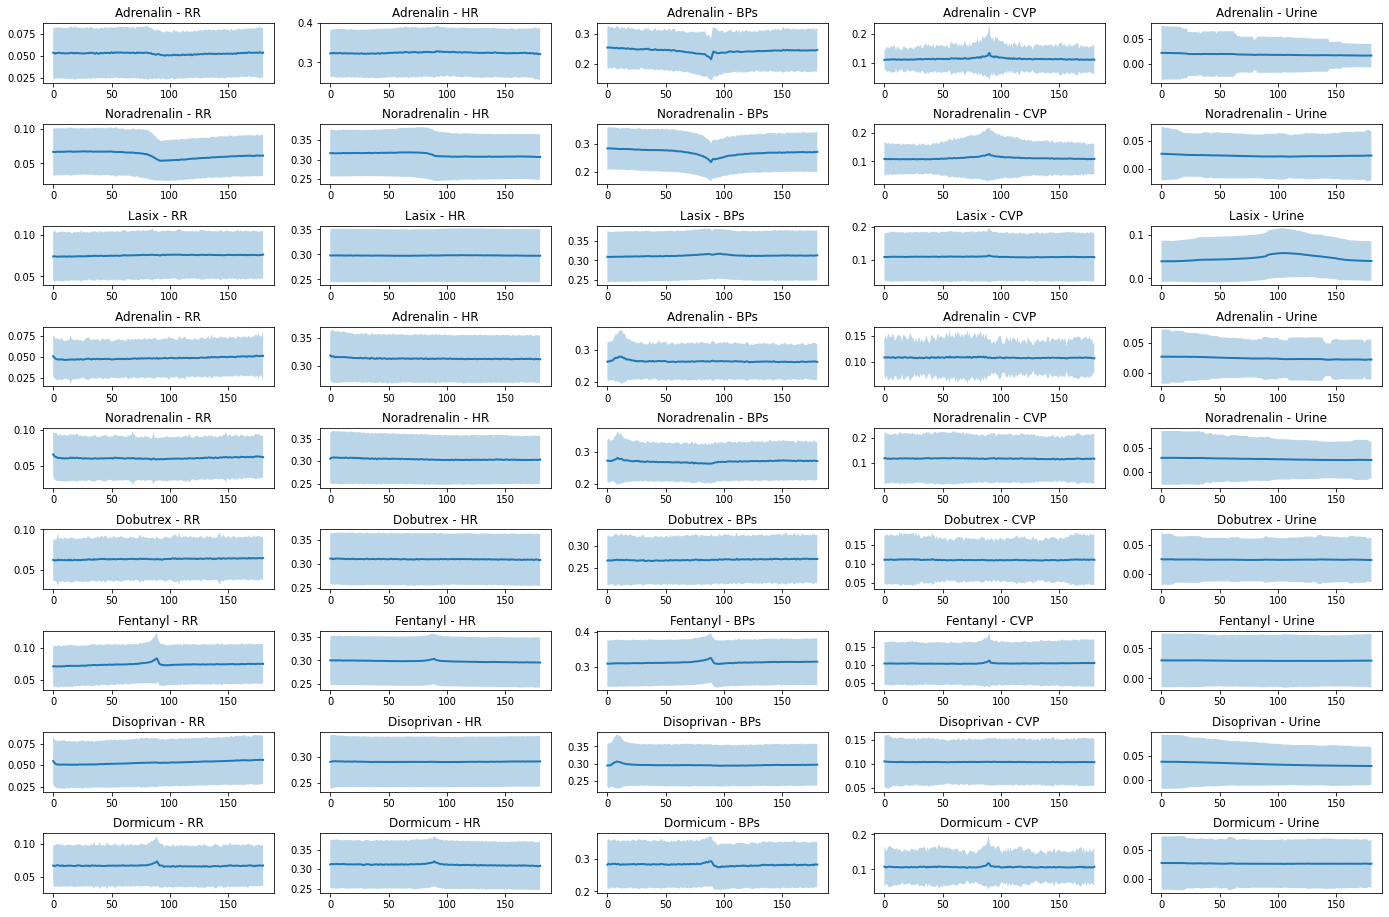

In [252]:
fig, ax = plt.subplots(9, 5, figsize=(30,16))
plt.subplots_adjust(hspace=.7)
idx_vital = {
    11: 'RR',
    12: 'HR',
    13: 'BPs',
    16: 'CVP',
    17: 'Urine'
}


for j, pharmaid in enumerate(INPUT_OF_INTEREST[:-1]):
    idx_pharma = np.where(labels['pharmaid'] == pharmaid)[0]
    pharmaname = selected_pharma.loc[selected_pharma['variableid']==pharmaid, 'variablename'].item()
    pharmaname = pharmaname.split(' ')[0]
    
    sample = samples[idx_pharma]
    sample[sample==-1] = np.nan

    mean = np.nanmean(sample, axis=0)
    std = np.nanstd(sample, axis=0)
    
    for i, vitalid in enumerate(idx_vital):
#         idx_sub = np.random.choice(sample.shape[0], 30)
#         for idx in idx_sub:
#             ax[j][i].plot(sample[idx, :, vitalid], color='gray');
            
        ax[j][i].plot(mean[:, vitalid], linewidth=2);
        ax[j][i].fill_between(range(181), 
                        mean[:, vitalid]-std[:, vitalid], 
                        mean[:, vitalid]+std[:, vitalid] , 
                        alpha=.3)
    #     ax.set_ylim(0.2, 0.4)
        ax[j][i].set_title(f'{pharmaname} - {idx_vital[vitalid]}')

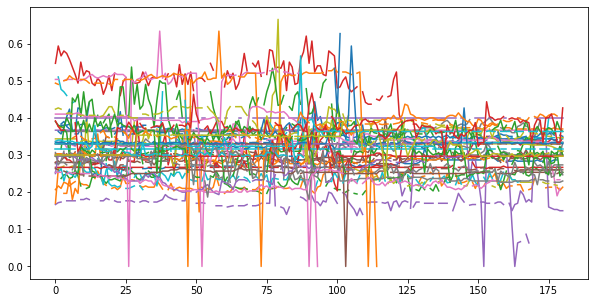

In [211]:
idx_sub = np.random.choice(sample_adrenalin.shape[0], 50)
fig, ax = plt.subplots(1, 1, figsize=(10,5))

for idx in idx_sub:
    ax.plot(sample_adrenalin[idx, :, 12]);